In [1]:
!pip install num2words keras-tuner

     |████████████████████████████████| 163 kB 848 kB/s            
     |████████████████████████████████| 129 kB 2.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=358fd38ec59c19856bd9c703bb81e3574468711978032d6c64ce09cad7eb50fa
  Stored in directory: /aiffel/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 

from utils import *

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load preprocessed amazon review dataset from directory
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/preprocessed_news.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))
data.sample(20)

전체 샘플수 : 98360


,headlines,text
23534,indonesia invites kim jong un attend asian games,indonesia invited north korean leader kim jong...
29078,salman trained first arjuna awardee cricketer,bollywood actor salman khan trained former ind...
72614,want apology kangana ranaut hrithik row,promotional video aap ki adalat kangana ranaut...
20021,hackers onest attempt rob cosmos bank ninety f...,first attempt hackers stole ninety four crore ...
27417,remo refutes rumours fallout salman post race ...,choreographer turned filmmaker remo souza deni...
32927,kapil sends one hundred cr notice editor deman...,comedian kapil sharma sent legal notice one hu...
9054,media twists statements address press taka cm,karnataka cm hd kumaraswamy thursday reportedl...
28102,take marriage films right reasons masaan actress,masaan actress shweta tripathi got married boy...
7268,selling dhoni ipl one still career highlight a...,auctioneer richard madley replaced hugh edmead...
16829,fatima look zafira thugs hindostan revealed,fatima sana shaikh look zafira thugs hindostan...


### 데이터 전처리

##### 1) train / test split

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 95
텍스트의 평균 길이 : 38.582035380235865
요약문의 최소 길이 : 1
요약문의 최대 길이 : 23
요약문의 평균 길이 : 7.899339162261081


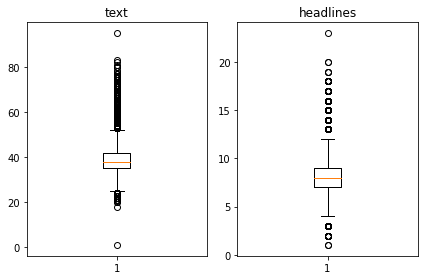

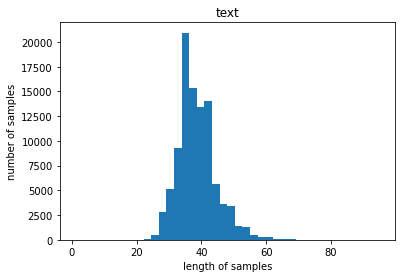

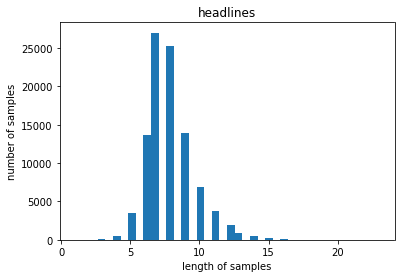

In [4]:
# 샘플의 텍스트/요약문 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약문의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약문의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약문의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [5]:
# mean + 2*std를 텍스트 길이의 상한선으로 설정 -> 손실되는 text 5% 미만
text_max_len = int(np.mean(text_len) + 2 * np.std(text_len))
print(text_max_len)

summary_max_len = int(np.mean(summary_len) + 2 * np.std(summary_len))
print(summary_max_len)

50
11


In [6]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9583367222448149
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9613359089060594


In [7]:
data = data[(data["text"].apply(lambda x: len(x.split()) <= text_max_len)) & 
(data["headlines"].apply(lambda x: len(x.split()) <= summary_max_len))]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 91643


In [8]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al ninety pe...,saurav kant alumnus upgrad iit pg program mach...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al ninety pe...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india twelve ...,new zealand defeated india eight wickets fourt...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india twelve ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [9]:
# numpy array로 저장
encoder_input = np.array(data['text']) 
decoder_input = np.array(data['decoder_input']) 
decoder_target = np.array(data['decoder_target']) 

In [10]:
en_x_train, en_x_test, de_x_train, de_x_test, de_y_train, de_y_test = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.2)

In [11]:
print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

훈련 데이터의 개수 : 73314
훈련 레이블의 개수 : 73314
테스트 데이터의 개수 : 18329
테스트 레이블의 개수 : 18329


##### 2) 정수 인코딩

In [12]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(en_x_train)

In [13]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68292
등장 빈도가 8번 이하인 희귀 단어의 수: 49345
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18947
단어 집합에서 희귀 단어의 비율: 72.25590113043988
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.138093264886246


In [14]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(en_x_train) # 단어 집합 재생성

In [15]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
en_x_train_tk = src_tokenizer.texts_to_sequences(en_x_train) 
en_x_test_tk = src_tokenizer.texts_to_sequences(en_x_test)

# 잘 진행되었는지 샘플 출력
print(en_x_train_tk[:3])

[[1198, 252, 185, 730, 412, 390, 218, 1, 2, 2210, 831, 4386, 713, 4204, 955, 730, 2152, 2152, 6, 157, 1377, 730, 13, 98, 268, 633, 2, 146, 210, 539], [12, 8, 3, 7751, 4428, 182, 375, 1899, 802, 1403, 4680, 183, 72, 14, 593, 27, 25, 3, 7112, 428, 18948, 702, 493, 9, 31, 3, 24, 5, 2, 3, 106, 85, 3, 31, 5, 2, 3, 109, 134, 486, 103, 3, 1665, 2367, 4644, 14], [12163, 817, 2543, 1549, 610, 2, 1935, 175, 1374, 1605, 10, 430, 262, 43, 9, 6123, 3367, 1093, 63, 34, 803, 389, 515, 77, 371, 923, 803, 9532, 8400, 13, 52, 10, 430, 262, 5907, 500, 1908, 49, 223, 1003, 541]]


In [16]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(de_x_train)

In [17]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29729
등장 빈도가 5번 이하인 희귀 단어의 수: 19547
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10182
단어 집합에서 희귀 단어의 비율: 65.7506138787043
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.870905575533905


In [18]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(de_x_train)
tar_tokenizer.fit_on_texts(de_y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
de_x_train_tk = tar_tokenizer.texts_to_sequences(de_x_train) 
de_y_train_tk = tar_tokenizer.texts_to_sequences(de_y_train)
de_x_test_tk = tar_tokenizer.texts_to_sequences(de_x_test)
de_y_test_tk = tar_tokenizer.texts_to_sequences(de_y_test)

# 잘 변환되었는지 확인
print('decoder input: ', de_x_train_tk[:5])
print('decoder target: ', de_y_train_tk[:5])

decoder input:  [[1, 444, 3236, 3236, 466, 454], [1, 14, 10, 7, 324, 220, 8544, 467, 1314, 4950], [1, 1854, 3021, 11, 343, 9284, 105, 11, 343, 1787, 35, 82], [1, 1665, 5600, 624, 680, 759, 5601, 6912], [1, 2083, 592, 1416, 262, 437, 5886, 734, 1666, 46]]
decoder target:  [[444, 3236, 3236, 466, 454, 2], [14, 10, 7, 324, 220, 8544, 467, 1314, 4950, 2], [1854, 3021, 11, 343, 9284, 105, 11, 343, 1787, 35, 82, 2], [1665, 5600, 624, 680, 759, 5601, 6912, 2], [2083, 592, 1416, 262, 437, 5886, 734, 1666, 46, 2]]


In [19]:
drop_train = [index for index, sentence in enumerate(de_x_train_tk) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(de_x_test_tk) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

en_x_train_tk = [sentence for index, sentence in enumerate(en_x_train_tk) if index not in drop_train]
de_x_train_tk = [sentence for index, sentence in enumerate(de_x_train_tk) if index not in drop_train]
de_y_train_tk = [sentence for index, sentence in enumerate(de_y_train_tk) if index not in drop_train]

en_x_test_tk = [sentence for index, sentence in enumerate(en_x_test_tk) if index not in drop_test]
de_x_test_tk = [sentence for index, sentence in enumerate(de_x_test_tk) if index not in drop_test]
de_y_test_tk = [sentence for index, sentence in enumerate(de_y_test_tk) if index not in drop_test]

print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 73314
훈련 레이블의 개수 : 73314
테스트 데이터의 개수 : 18329
테스트 레이블의 개수 : 18329


In [20]:
en_x_train_tk = pad_sequences(en_x_train_tk, maxlen=text_max_len, padding='post')
en_x_test_tk = pad_sequences(en_x_test_tk, maxlen=text_max_len, padding='post')
de_x_train_tk = pad_sequences(de_x_train_tk, maxlen=summary_max_len, padding='post')
de_x_test_tk = pad_sequences(de_x_test_tk, maxlen=summary_max_len, padding='post')
de_y_train_tk = pad_sequences(de_y_train_tk, maxlen=summary_max_len, padding='post')
de_y_test_tk = pad_sequences(de_y_test_tk, maxlen=summary_max_len, padding='post')

### 모델 설계

In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

##### Encoder

In [28]:
embedding_dim = 512
hidden_size = 512

# 인코더 input
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

##### Decoder

In [29]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [30]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 512)      10240000    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 512), (N 2099200     embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### training & test

##### training

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[en_x_train_tk, de_x_train_tk], y=de_y_train_tk, \
          validation_data=([en_x_test_tk, de_x_test_tk], de_y_test_tk), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
144/144 [==============================] - 79s 517ms/step - loss: 5.7426 - val_loss: 5.2981
Epoch 2/50
144/144 [==============================] - 73s 509ms/step - loss: 5.2835 - val_loss: 5.1724
Epoch 3/50
144/144 [==============================] - 74s 512ms/step - loss: 5.1693 - val_loss: 5.0699
Epoch 4/50
144/144 [==============================] - 74s 517ms/step - loss: 5.0049 - val_loss: 4.8772
Epoch 5/50
144/144 [==============================] - 74s 517ms/step - loss: 4.7857 - val_loss: 4.6848
Epoch 6/50
144/144 [==============================] - 74s 518ms/step - loss: 4.5559 - val_loss: 4.4828
Epoch 7/50
144/144 [==============================] - 75s 518ms/step - loss: 4.3268 - val_loss: 4.3155
Epoch 8/50
144/144 [==============================] - 75s 518ms/step - loss: 4.1150 - val_loss: 4.1582
Epoch 9/50
144/144 [==============================] - 75s 518ms/step - loss: 3.9074 - val_loss: 4.0271
Epoch 10/50
144/144 [==============================] - 75s 519ms/step - l

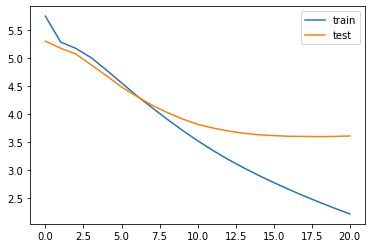

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### inference

In [33]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어

inference model design

In [34]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [35]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
for i in range(50):
    print("원문 :", seq2text(en_x_test_tk[i], src_index_to_word))
    print("실제 요약 :", seq2summary(de_x_test_tk[i], tar_word_to_index, tar_index_to_word))
    print("예측 요약 :", decode_sequence(en_x_test_tk[i].reshape(1, text_max_len)))
    print("\n")

원문 : expressing condolences following demise former pm atal bihari vajpayee tibetan spiritual leader dalai lama said feel privileged known honoured counted friend added shri vajpayee truly dedicated politician passing away india lost eminent national leader 
실제 요약 : honoured vajpayee friend dalai lama 
예측 요약 :  proud nehru ratna pm modi


원문 : cricket australia tweeted video india celebrating test series victory australia india captain virat kohli called pujara dance pujara walks move hands dance extension walk rishabh pant came kohli explained pujara could even see simple added 
실제 요약 : india celebrate australia test series victory pujara dance 
예측 요약 :  kohli calls australian captain williamson root


원문 : karnataka asked supreme court review decision drop proceedings late tamil nadu cm jayalalithaa disproportionate assets case saying recover one hundred crore fine estate sale sc earlier overturned karnataka high court order giving clean chit jayalalithaa charges due death 
실제 요약 : r

예측 요약 :  philippine prez arrested sexual assault


원문 : customers bought jewellery using cash nirav modi stores two financial years starting two thousand fifteen sixteen income tax department scanner according reports investigation based list specified confidential document ninety pages prepared department data circulated relevant regional departments reports added 
실제 요약 : people bought jewellery nirav modi lens 
예측 요약 :  indigo fined one point five lakh clients


원문 : google launched sharing feature allows users share location route real time others maps ios devices using share trip progress option users choose contacts want share live location route users also share trip data across third party apps including facebook messenger whatsapp 
실제 요약 : google launches real time location sharing maps ios 
예측 요약 :  google maps lets users share users without location


원문 : us president donald trump said saudi crown prince mohammed bin salman could involved operation kill journalist jamal kha

예측 요약 :  kerala couples donate three lakh girls donate away


원문 : external affairs minister sushma swaraj wednesday said medical visas three pakistani nationals approved ministry external affairs one patients needs liver transplant given appointment chennai hospital october swaraj said india grant medical visas cases 
실제 요약 : medical visas three pakistanis approved sushma swaraj 
예측 요약 :  indian visa visa visa sushma swaraj


원문 : luke gone watch australia new zealand ttwentyi perth december eleven two thousand seven girlfriend parking car australia team manager called play match twenty three year old asked replace brad hodge injured back interestingly banned state side time disciplinary issues 
실제 요약 : player went see ttwentyi girlfriend went play match 
예측 요약 :  sa captain breaks ball tampering two hundred twenty four


원문 : message reading thanks seen painted rooftop house kochi naval piloted commander vijay varma rescued two women including pregnant woman august seventeen pregnant

### 추출적 요약 결과와 비교해보기(with 매트릭스 시놉시스 데이터셋)

In [45]:
import requests
from summa.summarizer import summarize

In [46]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [47]:
# 전체 문장의 0.5%만 요약문으로 추출
print('Summary:', summarize(text, ratio=0.005))

Summary: Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [48]:
# 요약문에 포함된 단어 수를 50개로 제한
print(summarize(text, words=50))

Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


- **추출적 요약**: 원본 문장에서 중요한 문장을 직접 가져오기 때문에 문장 내부적으로 문법의 오류가 없다. 하지만 핵심 개념이 중복될 수 있으며, 중요한 단어가 포함되지만 문맥이 부자연스러울 수도 있다.
- **추상적 요약**: 새로운 문장을 생성하여 더 압축적인 요약이 가능하며, 문맥이 상대적으로 매끄럽다. 하지만 문법적으로 부자연스럽거나, 원본 문장에서 사용된 특정한 핵심 단어가 포함되지 않을 가능성이 있다.

### Done

1. 데이터 전처리 함수
- 수치 데이터와 일부 특수기호도 중요한 정보인데 이것도 없애야 할까?
    - $ → ‘dollar’, % → ‘percent’, & → ‘and’로 변경하는 로직 추가
    - num2words 라이브러리로 숫자를 문자로 변경 (ex : 2000 → two thousands)
    - 숫자 사이에 콤마나 점이 있는 경우에 대응
        - 1.5를 one point five로 읽도록 수정
        - 1,000을 one zero로 읽는 문제 해결
- `sentence = re.sub("[m]{2,}", "mm", sentence)` → 다른 알파벳도 3개 이상 반복되면 2개로 바꾸는 로직 추가
- 'iso-8859-1’ 인코딩에 글씨 깨짐이 발생하는 경우가 있어 ‘utf-8’로 변경
<br/>
2. 하이퍼파라미터 튜닝 with keras tuner
    - embedding_dim : 512
    - hidden_size : 512
    - dropout : 0.4 -> 0.2
    - learning rate : 0.001 -> 0.0005

### To-do

1. 어텐션 메커니즘
    - Luong attention 분석
    - Bahdanau 모델 구현 & 성능 비교